## Inference using the trained model

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import math
import json

from IPython.display import Image, display
import random
import jieba

import numpy as np
import tensorflow as tf


import config
from im2txt_model import Im2TxtModel
import inference_wrapper
from inference_utils import caption_generator
from inference_utils import vocabulary

In [2]:
checkpoint_path="../model/semantic_attention_model_attr_only_wb/model.ckpt-36850"
#vocab_file="../data/word_counts.txt"
#attributes_file="../data/attributes.txt"
data_path="../data/"
# dev set
devset_path = os.path.join(data_path, "ai_challenger_caption_validation_20170910")
dev_image_path = os.path.join(devset_path, "caption_validation_images_20170910")
dev_annotation_path = os.path.join(devset_path, "caption_validation_annotations_20170910.json")

In [3]:
FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_string("vocab_file", "../data/word_counts.txt", "Text file containing the vocabulary.")
tf.flags.DEFINE_string("attributes_file", "../data/attributes.txt", "Text file containing the attributes.")


In [4]:
FLAGS.model = "SemanticAttentionModel"
FLAGS.attributes_top_k = 15

In [5]:
# load model
g = tf.Graph()
with g.as_default():
    tf.logging.info("Building model.")
    model = Im2TxtModel(mode="inference")
    model.build()
    saver = tf.train.Saver()
    if tf.gfile.IsDirectory(checkpoint_path):
      checkpoint_path = tf.train.latest_checkpoint(checkpoint_path)
      if not checkpoint_path:
        raise ValueError("No checkpoint file found in: %s" % checkpoint_path)

    def restore_fn(sess):
      tf.logging.info("Loading model from checkpoint: %s", checkpoint_path)
      saver.restore(sess, checkpoint_path)
      tf.logging.info("Successfully loaded checkpoint: %s",
                      os.path.basename(checkpoint_path))
    g.finalize()

INFO:tensorflow:Building model.
[1, 8, 8, 2048]


In [6]:
sess = tf.Session(graph=g)
restore_fn(sess)

INFO:tensorflow:Loading model from checkpoint: ../model/semantic_attention_model_attr_only_wb/model.ckpt-36850
INFO:tensorflow:Restoring parameters from ../model/semantic_attention_model_attr_only_wb/model.ckpt-36850
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-36850


In [7]:
vocab = vocabulary.Vocabulary(FLAGS.vocab_file)

INFO:tensorflow:Initializing vocabulary from file: ../data/word_counts.txt
INFO:tensorflow:Created vocabulary with 8562 words


In [8]:
def show_example(example, image_path):
    image_id = example['image_id']
    caption = example['caption']
    im = Image(filename=os.path.join(image_path, image_id)) 
    display(im)
    for c in caption:
        c = c.strip().strip(u"。").replace('\n', '')
        seg_list = jieba.cut(c, cut_all=False)
        print ' '.join(seg_list)
    #return image_id, caption

In [9]:
# read dev data
input = open(dev_annotation_path,'r')
dev_examples = json.load(input)
input.close()
dev_size = len(dev_examples)

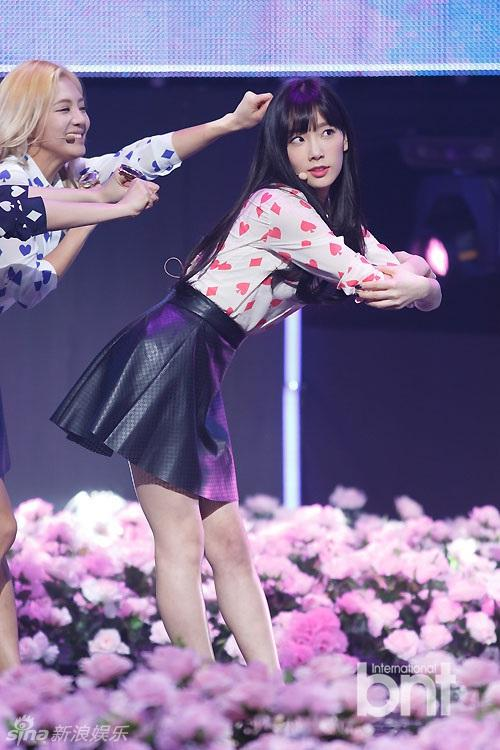

舞台 上 有 一个 双手 抬起 的 女人 和 一个 双臂 环抱 的 女人 在 表演
舞台 上 有 两个 穿着 各异 的 女人 在 跳舞
舞台 上 两个 双手 放在 身前 的 女人 在 表演
一个 穿着 短裙 的 女人 和 另 一个 女人 在 舞台 上 表演
一个 人 的 前面 有 一个 穿着 黑色 裙子 的 女人 在 舞台 上 表演
女人 拿 穿着 舞台 右手 左手 话筒 人 双手 衣服 球场上 走 女孩 抱 裙子
[ 0.98199618  0.60646033  0.46855658  0.44814482  0.22159179  0.1407647
  0.08389781  0.07765853  0.07661545  0.06872553  0.05857209  0.0376077
  0.0348324   0.03416469  0.03382313]
[10016 10016 10016  3416 11678  6505  6505  6505  6505  3642  3642  3642
  4250  8201  7671  4250 10092  4250 10092  4250]
<UNK> <UNK> <UNK> 大刀 <UNK> 折叠 折叠 折叠 折叠 化着 化着 化着 交换 削面 钻戒 交换 <UNK> 交换 <UNK> 交换
[10016 10016 10016  3416 11678  6505  6505  6505  6505  3642  3642  3642
  4250  8201  7671  4250 10092  4250  6889  6889]
<UNK> <UNK> <UNK> 大刀 <UNK> 折叠 折叠 折叠 折叠 化着 化着 化着 交换 削面 钻戒 交换 <UNK> 交换 做事 做事
[10016 10016 10016  3416 11678  6505  6505  6505  6505  3642  3642  3642
  4250  8201  7671  4250 10092  4250 10092  6889]
<UNK> <UNK> <UNK> 大刀 <UNK> 折叠 折叠 折叠 折叠 化着 化着 化着 交换 削面 钻戒 交换 <UNK> 交换 <UNK> 做事


In [19]:
# run a random image
index = int(random.random() * dev_size)
show_example(dev_examples[index], dev_image_path)
filename = os.path.join(dev_image_path, dev_examples[index]['image_id'])
f = tf.gfile.GFile(filename, "r")
image=f.read()

predicted_ids, scores, top_n_attributes = sess.run(
        [model.predicted_ids, model.scores, model.top_n_attributes],
        feed_dict={"image_feed:0": image})


predicted_ids = np.transpose(predicted_ids, (0,2,1))
scores = np.transpose(scores, (0,2,1))
attr_probs, attr_ids = top_n_attributes
attributes = [vocab.id_to_word(w) for w in attr_ids[0]]
print(" ".join(attributes))
print(attr_probs[0])
#print(top_n_attributes)
for caption in predicted_ids[0]:
    print(caption)
    caption = [id for id in caption if id >= 0 and id != FLAGS.end_token]
    sent = [vocab.id_to_word(w) for w in caption]
    print(" ".join(sent))


